In [1]:
import numpy as np
from scipy.stats import norm

import torch
torch.manual_seed(0)
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tsformer import TimeSeriesTransformer

import matplotlib.pyplot as plt

In [2]:
def black_scholes_call(S, K, T, r, sigma):

    S = S[..., None, :]  # (num_simulation, num_asset, 1, num_step)
    K = K[None, ..., None]  # (1, num_asset, num_strike, 1)
    T = T[None, None, None, :]  # (1, 1, 1, Step_num)
    sigma = sigma[None, :, None, None]  # (1, num_asset, 1, 1)
    
    # Handle expiration case
    call_prices = np.maximum(0, S - K) * (T <= 0)
    
    # Calculate d1 and d2
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    call_prices = np.where(T > 0, S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2), call_prices)
    
    return call_prices # (num_simulation, num_asset, num_strike, num_step)

def black_scholes_delta(S, K, T, r, sigma):

    S = S[..., None, :]  # (num_simulation, num_asset, 1, num_step)
    K = K[None, ..., None]  # (1, num_asset, Num_unique_K, 1)
    T = T[None, None, None, :]  # (1, 1, 1, num_step)
    sigma = sigma[None, :, None, None]  # (1, num_asset, 1, 1)
    
    # Handle expiration case
    delta = np.where(T <= 0, np.where(S > K, 1.0, 0.0), 0.0)
    
    # Calculate d1
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    
    # Calculate delta
    delta = np.where(T > 0, norm.cdf(d1), delta)
    
    return delta # (num_simulation, num_asset, num_strike, num_step)

def update_cash_account(init_cash_account, shares_to_trade, stock_prices, r, T):

    # a_0 = b_0
    # a_1 = a_0 * r + b_1 = b_0 * r + b_1
    # a_2 = a_1 * r + b_2 = b_0 * r^2 + b_1 *r + b_2
    # a_n = a_{n-1}*r + b_n
    # def calculate_a_series(b, r):
    #     n = len(b)
    #     r_powers = r ** np.arange(n)
    #     a_series = np.cumsum(b * r_powers[::-1])[::-1] / r_powers
    #     return a_series[::-1]

    b = np.concat((init_cash_account[...,None], - shares_to_trade * stock_prices[...,None,1:]),axis=-1)
    r_powers = np.exp(r*T)[None, None, None,:]
    a_series = np.cumsum(b * r_powers,axis=-1)[...,::-1] / r_powers[...,::-1]
    a_series = a_series[...,::-1]
    return a_series


def generate_data(S0, K, sigma, r, num_simulation, num_step, seed):
    
    np.random.seed(seed)

    T = np.linspace(1, 0, num_step+1)  # Time to maturity
    dt = 1 / num_step

    num_asset = len(S0)
    num_strike = K.shape[1]
    S0 = np.tile(S0, (num_simulation,1))[...,None]

    # Simulatation
    z = np.random.normal(0, 1, (num_simulation, num_asset, num_step))
    log_returns = (r - 0.5 * sigma[None,:,None]**2) * dt + sigma[None,:,None] * np.sqrt(dt) * z
    log_S = np.log(S0) + np.cumsum(log_returns, axis=-1)
    stock_prices = np.exp(log_S)
    stock_prices = np.concatenate((S0, stock_prices), axis=-1)

    # Options and Deltas
    option_prices = black_scholes_call(stock_prices, K, T, r, sigma)
    deltas = black_scholes_delta(stock_prices, K, T, r, sigma)

    # Portfolio
    shares_held = deltas
    shares_to_trade = shares_held[...,1:] - shares_held[...,:-1]

    cash_account = np.zeros((num_simulation, num_asset, num_strike, num_step+1))

    init_cash_account = option_prices[..., 0] - shares_held[..., 0] * S0
    cash_account = update_cash_account(init_cash_account, shares_to_trade, stock_prices, r, T)

    portfolio_value = cash_account + shares_held * stock_prices[...,None,:]

    print(np.mean(np.abs(option_prices-portfolio_value)))

    return T, stock_prices, deltas, option_prices, portfolio_value

In [3]:
def create_features(stock_prices, K, T, r):

    # stock_prices: (num_asset, num_step+1)
    # K: (num_strike)
    # T: (num_step+1)
    # r: risk-free rate (scalar)

    num_asset, num_step_plus_one = stock_prices.shape
    num_strike = K.shape[1]

    # Expand stock_prices to align with strikes
    stock_prices_expanded = stock_prices[:, None, :].repeat(1, num_strike, 1) # (num_asset, num_strike, num_step+1)
    K_expanded = K[..., None].repeat(1, 1, num_step_plus_one) # (num_asset, num_strike, num_step+1)
    T_expanded = T[None, None, :].repeat(num_asset, num_strike, 1) # (num_asset, num_strike, num_step+1)
    r_expanded = torch.tensor([r], device=stock_prices.device).reshape(1, 1, 1).repeat(num_asset, num_strike, num_step_plus_one) # (num_asset, num_strike, num_step+1)


    # Reshape for batching
    stock_prices_reshaped = stock_prices_expanded.reshape(num_asset * num_strike, num_step_plus_one)
    K_reshaped = K_expanded.reshape(num_asset * num_strike, num_step_plus_one)
    T_reshaped = T_expanded.reshape(num_asset * num_strike, num_step_plus_one)
    r_reshaped = r_expanded.reshape(num_asset * num_strike, num_step_plus_one)

    stock_price_change = stock_prices_reshaped[:, 1:] / stock_prices_reshaped[:, :-1]
    stock_price_log_change = torch.log(stock_price_change)
    moneyness = K_reshaped[:, 1:] / stock_prices_reshaped[:, 1:]
    moneyness_log = torch.log(moneyness)
    time_to_maturity = T_reshaped[:, 1:]
    risk_free_rate_feature = r_reshaped[:, 1:] # Constant risk-free rate

    features = torch.cat([
        stock_price_change.unsqueeze(-1),
        stock_price_log_change.unsqueeze(-1),
        moneyness.unsqueeze(-1),
        moneyness_log.unsqueeze(-1),
        time_to_maturity.unsqueeze(-1),
        risk_free_rate_feature.unsqueeze(-1),
    ], dim=-1) # (num_asset * num_strike, num_step, num_features)

    return features

In [4]:
class DeltaHedgingDataset(Dataset):

    def __init__(self, S0, K, sigma, r, num_simulation, num_step, seed):

        self.num_simulation = num_simulation
        T, stock_prices, deltas, option_prices, portfolio_value = generate_data(S0, K, sigma, r, num_simulation, num_step, seed)
        self.K = torch.tensor(K, dtype=torch.float32)
        self.T = torch.tensor(T, dtype=torch.float32)
        self.stock_prices = torch.tensor(stock_prices, dtype=torch.float32)
        self.deltas = torch.tensor(deltas, dtype=torch.float32)
        self.option_prices = torch.tensor(option_prices, dtype=torch.float32)
        self.portfolio_value = torch.tensor(portfolio_value, dtype=torch.float32)
        self.r = r

    def __len__(self):
        
        return self.num_simulation

    def __getitem__(self, idx):

        stock_prices = self.stock_prices[idx]
        option_prices = self.option_prices[idx]
        initial_deltas = self.deltas[idx,...,0:1]
        features = create_features(stock_prices, self.K, self.T, self.r)
        targets = self.deltas[idx,...,1:].reshape(-1, self.deltas.shape[-1]-1,1)

        return stock_prices, option_prices, initial_deltas, features, targets

In [5]:
def update_cash_account_torch(init_cash_account, shares_to_trade, stock_prices, r, T):

    b = torch.cat((init_cash_account[..., None], - shares_to_trade * stock_prices[...,None,1:]),dim=-1)
    r_powers = torch.exp(r*T)[None, None, None, :]
    a_series = torch.flip(torch.cumsum(b * r_powers,dim=-1), dims=[-1]) / torch.flip(r_powers, dims=[-1])
    a_series = torch.flip(a_series, dims=[-1])
    
    return a_series

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# Model and Training
input_dim = 6
output_dim = 1
hidden_size = 64
num_layers = 2
num_heads = 2
learning_rate = 0.001
num_epochs = 10
batch_size = 64
dropout_rate = 0.0
direct_supervision = False

model = TimeSeriesTransformer(
    input_dim=input_dim,
    embed_dim=hidden_size,
    num_layers=num_layers,
    num_heads=num_heads,
    dropout=dropout_rate,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [8]:
S0 = np.array([50.0, 100.0, 200.0])  # Initial stock prices
K = np.array([[45.0, 55.0], [90.0, 110.0], [180.0, 220.0]])  # Different strike prices for different stocks
sigma = np.array([0.15, 0.2, 0.25]) # Different volatilities for different stocks
r = 0.05  # Risk-free rate

num_simulation = 10_000
num_step = 260

num_asset = len(S0)
num_strike = K.shape[1]

In [9]:
train_dataset = DeltaHedgingDataset(S0, K, sigma, r, num_simulation, num_step, 0)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

test_dataset = DeltaHedgingDataset(S0, K, sigma, r, 1, num_step, 1)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=False)

/tmp/ipykernel_1139129/1378536276.py:12: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
/tmp/ipykernel_1139129/1378536276.py:30: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


0.2216962044382141
0.22851051694099045


In [10]:
def calc_portfolio_value(batch_stock_prices, batch_option_prices, batch_initial_deltas, batch_features):
    batch_size, num_asset, num_strike = batch_option_prices.shape[0:3]
    batch_stock_prices, batch_option_prices, batch_initial_deltas, batch_features = batch_stock_prices.to(device), batch_option_prices.to(device), batch_initial_deltas.to(device), batch_features.to(device)
    batch_features = batch_features.view(-1, num_step, input_dim)
    predicted_deltas = model(batch_features)
    predicted_deltas = predicted_deltas.reshape(batch_size, num_asset, num_strike, num_step)
    deltas = torch.cat((batch_initial_deltas, predicted_deltas), dim=-1)
    shares_held = deltas
    shares_to_trade = shares_held[...,1:] - shares_held[...,:-1]
    
    init_cash_account = batch_option_prices[..., 0] - shares_held[..., 0] * torch.tile(torch.tensor(S0, device=device, dtype=torch.float32), (batch_size,1))[...,None]
    cash_account = update_cash_account_torch(init_cash_account, shares_to_trade, batch_stock_prices, r, torch.linspace(1, 0, num_step+1, device=device))

    portfolio_value = cash_account + shares_held * batch_stock_prices[...,None,:]
    return batch_option_prices, portfolio_value

In [11]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch_stock_prices, batch_option_prices, batch_initial_deltas, batch_features, batch_targets in train_dataloader:
        optimizer.zero_grad()

        if direct_supervision:
            batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)
            batch_features = batch_features.view(-1, num_step, input_dim)
            predicted_deltas = model(batch_features)
            loss = criterion(predicted_deltas, batch_targets.view(-1, num_step, 1))
        else:
            batch_option_prices, portfolio_value = calc_portfolio_value(batch_stock_prices, batch_option_prices, batch_initial_deltas, batch_features)
            loss = criterion(batch_option_prices, portfolio_value)
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

    model.eval()
    with torch.no_grad():
        for batch_stock_prices, batch_option_prices, batch_initial_deltas, batch_features, batch_targets in test_dataloader:
            batch_option_prices, portfolio_value = calc_portfolio_value(batch_stock_prices, batch_option_prices, batch_initial_deltas, batch_features)
        print(f"Test Mean Abs Diff (Portfolio vs Option Price): {torch.mean(torch.abs(batch_option_prices-portfolio_value)):.6f}")

Epoch [1/10], Average Loss: 0.4428
Test Mean Abs Diff (Portfolio vs Option Price): 0.960517
Epoch [2/10], Average Loss: 0.0309
Test Mean Abs Diff (Portfolio vs Option Price): 0.675319
Epoch [3/10], Average Loss: 0.0164
Test Mean Abs Diff (Portfolio vs Option Price): 0.443016
Epoch [4/10], Average Loss: 0.0087
Test Mean Abs Diff (Portfolio vs Option Price): 0.356562
Epoch [5/10], Average Loss: 0.0070
Test Mean Abs Diff (Portfolio vs Option Price): 0.339565
Epoch [6/10], Average Loss: 0.0060
Test Mean Abs Diff (Portfolio vs Option Price): 0.329028
Epoch [7/10], Average Loss: 0.0055
Test Mean Abs Diff (Portfolio vs Option Price): 0.346210
Epoch [8/10], Average Loss: 0.0052
Test Mean Abs Diff (Portfolio vs Option Price): 0.365658
Epoch [9/10], Average Loss: 0.0050
Test Mean Abs Diff (Portfolio vs Option Price): 0.378636
Epoch [10/10], Average Loss: 0.0051
Test Mean Abs Diff (Portfolio vs Option Price): 0.400495


In [12]:
batch_size = 5
test_dataset = DeltaHedgingDataset(S0, K, sigma, r, batch_size, num_step, 0)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

0.16575229385490406


/tmp/ipykernel_1139129/1378536276.py:12: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
/tmp/ipykernel_1139129/1378536276.py:30: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


In [13]:
model.eval()
with torch.no_grad():
    for batch_stock_prices, batch_option_prices, batch_initial_deltas, batch_features, batch_targets in test_dataloader:
        batch_option_prices, portfolio_value = calc_portfolio_value(batch_stock_prices, batch_option_prices, batch_initial_deltas, batch_features)
    print(f"Mean Abs Diff (Portfolio vs Option Price): {torch.mean(torch.abs(batch_option_prices-portfolio_value)):.6f}")

Mean Abs Diff (Portfolio vs Option Price): 0.362935


In [14]:
option_prices_np = batch_option_prices.cpu().numpy()
portfolio_value_np = portfolio_value.cpu().numpy()

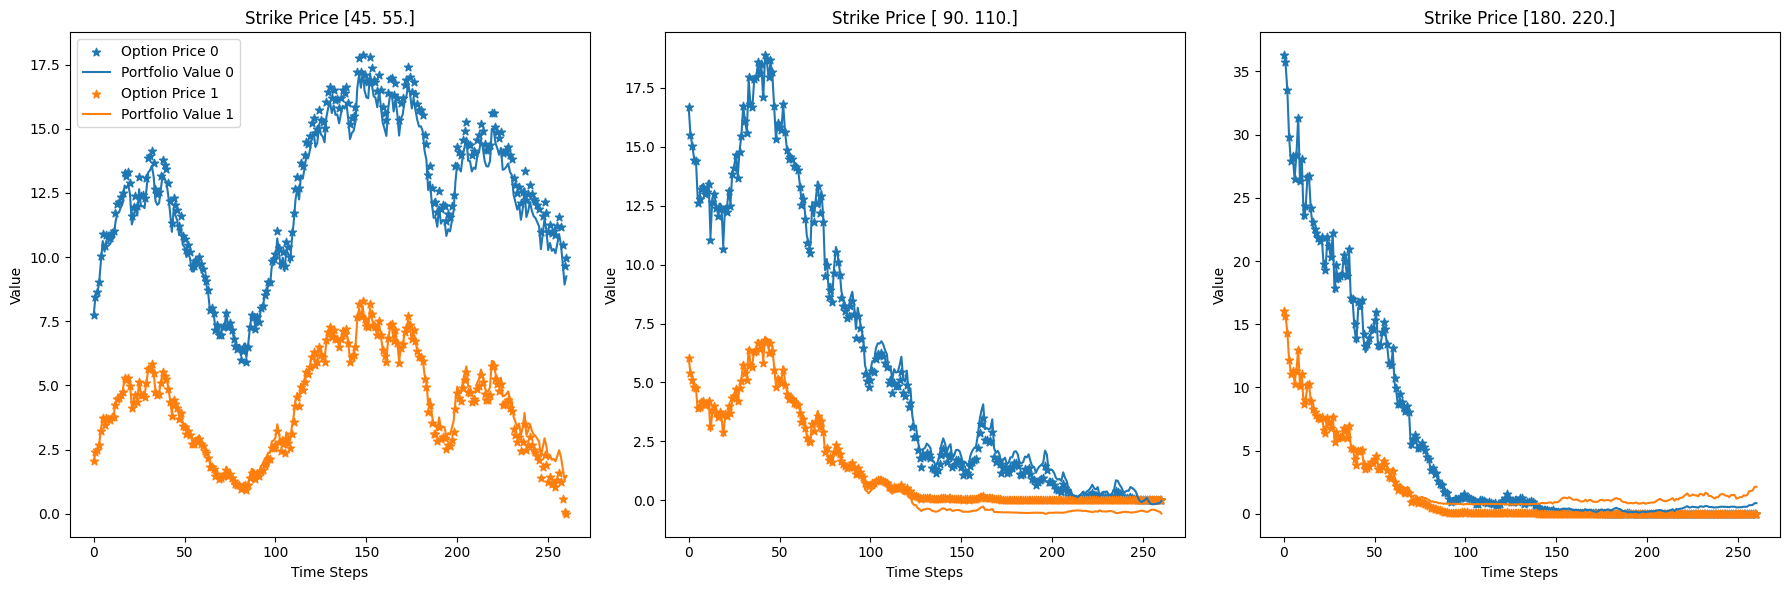

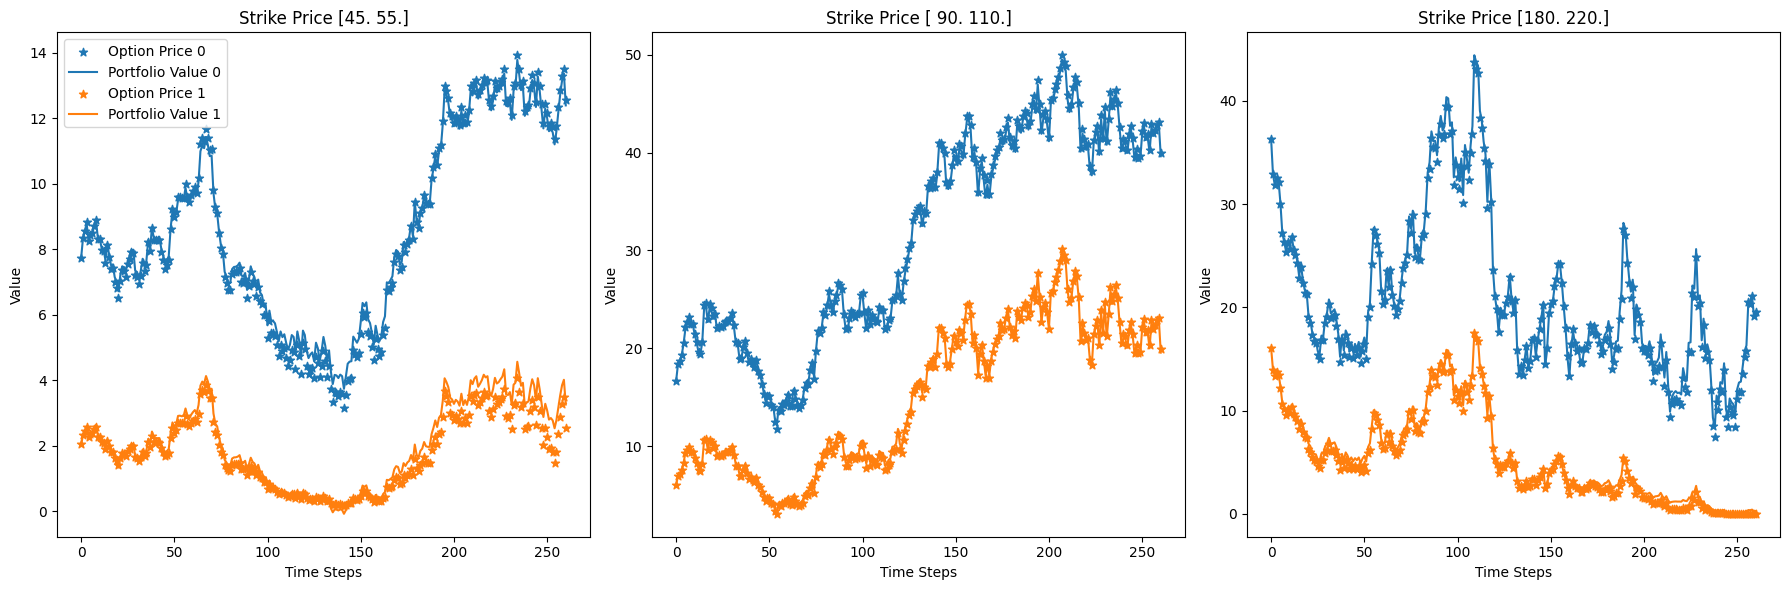

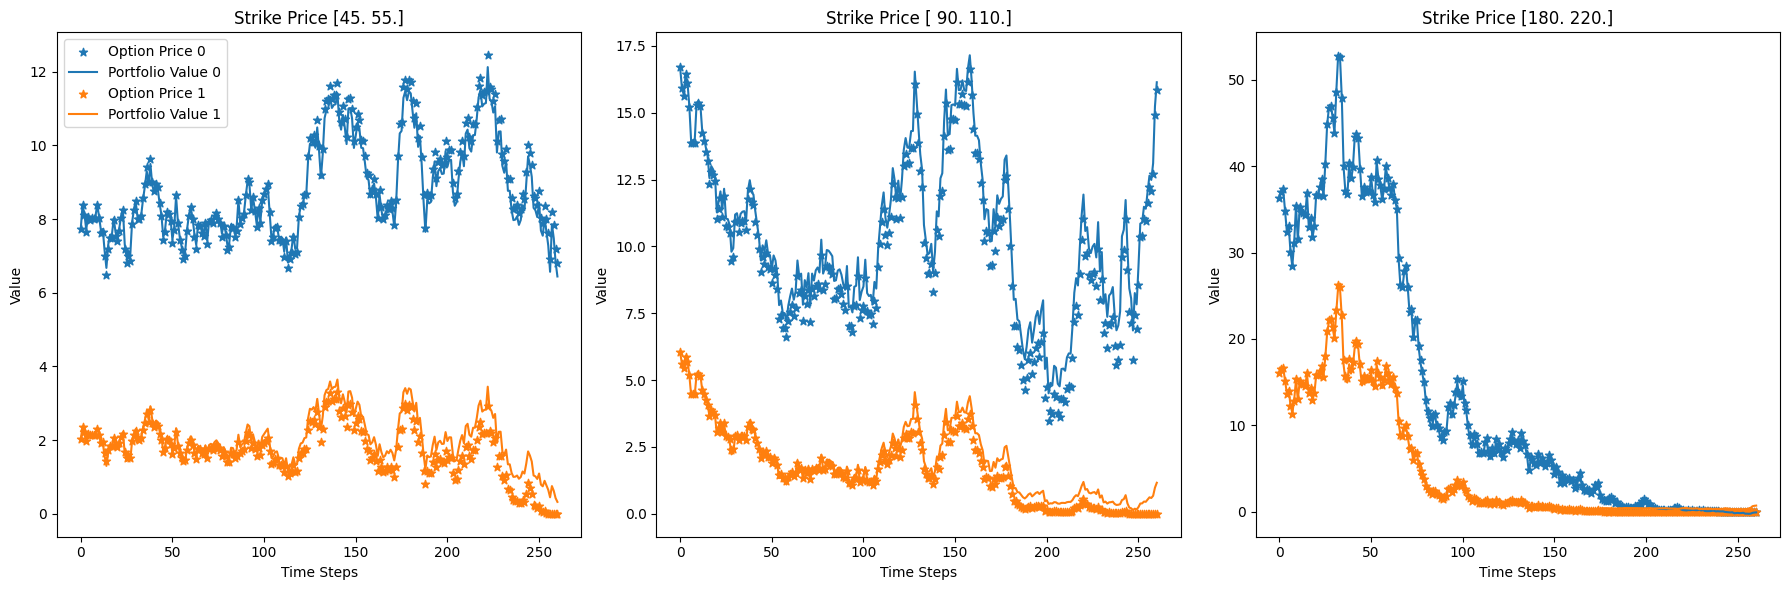

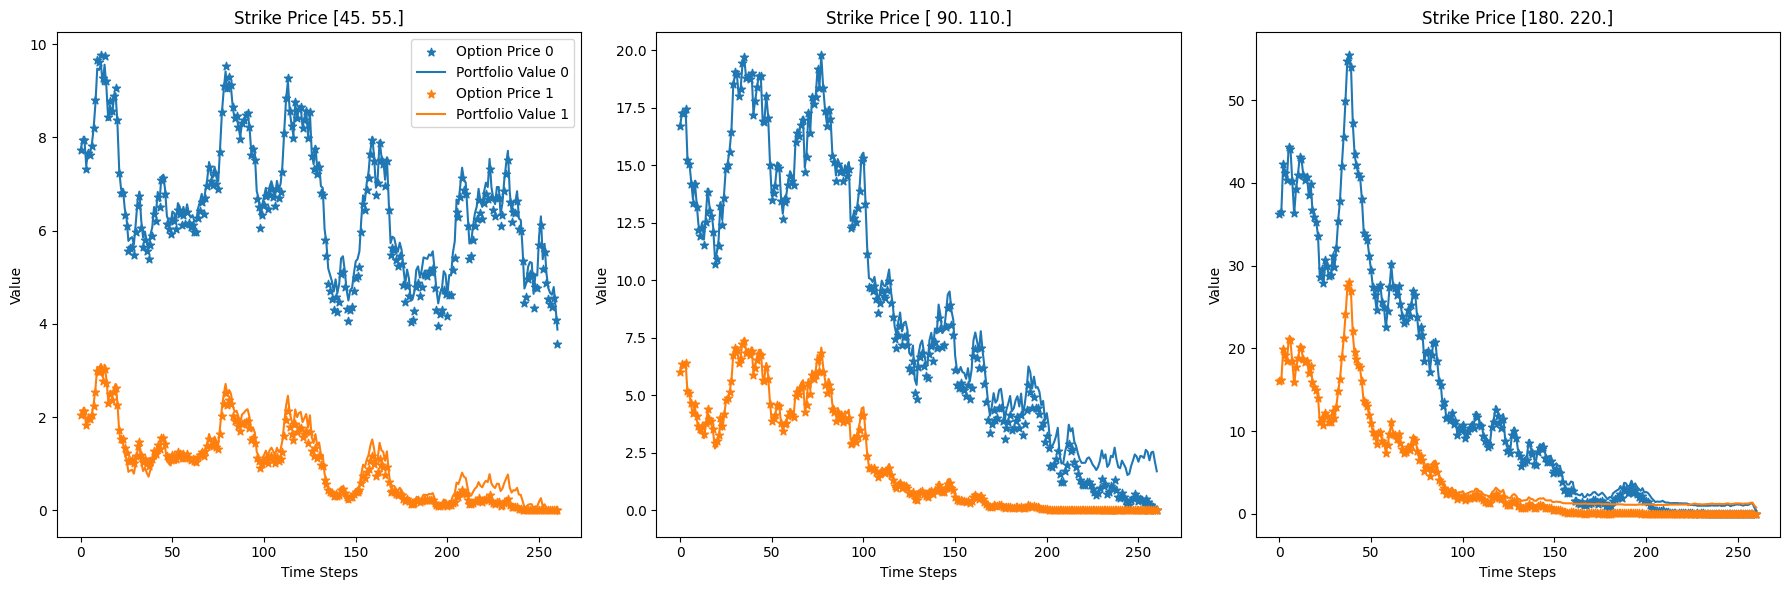

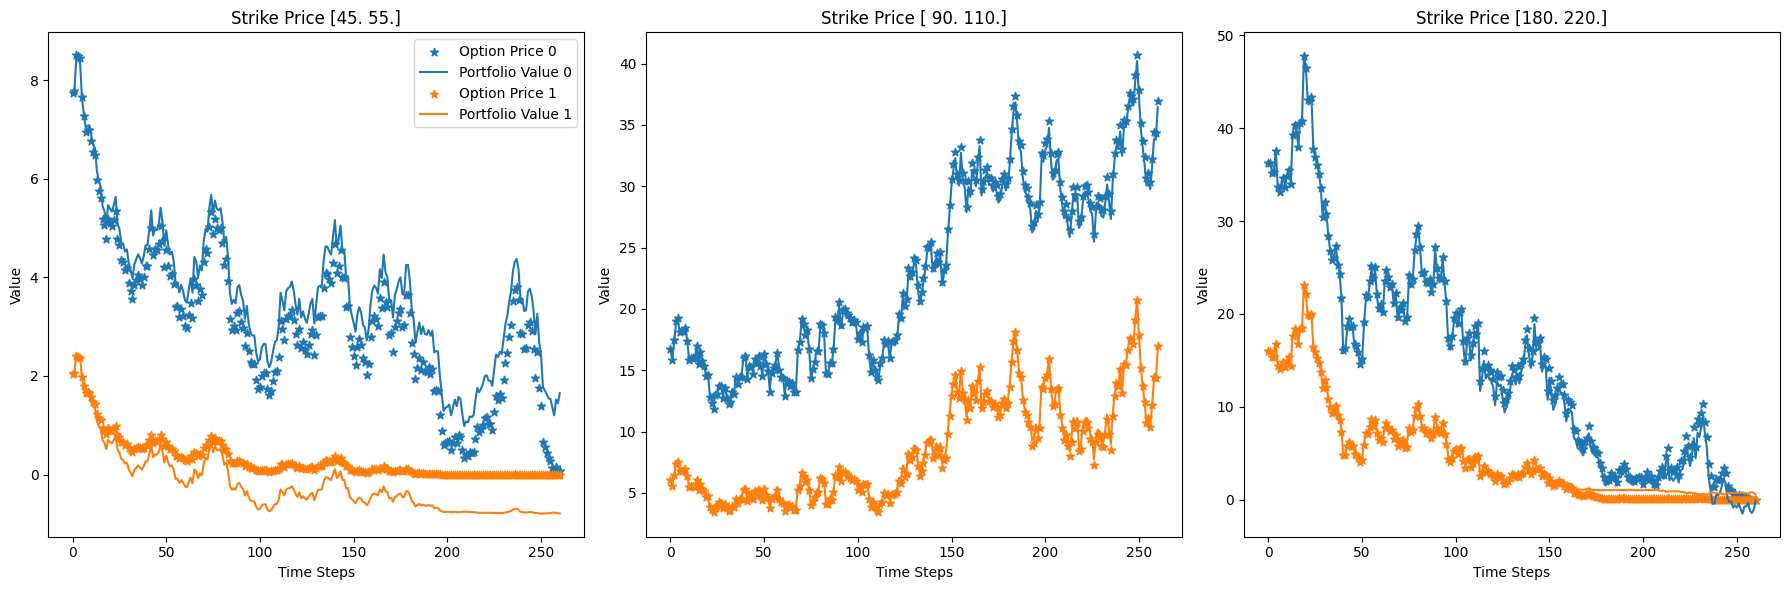

In [15]:
# Plotting the option prices and portfolio values
for idx in range(batch_size):
    fig, axes = plt.subplots(1, len(K), figsize=(18, 6))

    for i in range(num_asset):
        for j in range(num_strike):
            axes[i].scatter(range(option_prices_np.shape[-1]), option_prices_np[idx, i, j, :], marker='*', label=f'Option Price {j}' if i == 0 else "")
            axes[i].plot(portfolio_value_np[idx, i, j, :], linestyle='-', label=f'Portfolio Value {j}' if i == 0 else "")
        axes[i].set_title(f'Strike Price {K[i]}')
        axes[i].set_xlabel('Time Steps')
        axes[i].set_ylabel('Value')
        if i == 0:
            axes[i].legend()

    plt.tight_layout()
    plt.show()

In [16]:
option_prices_np = test_dataset.option_prices.numpy()
portfolio_value_np = test_dataset.portfolio_value.numpy()

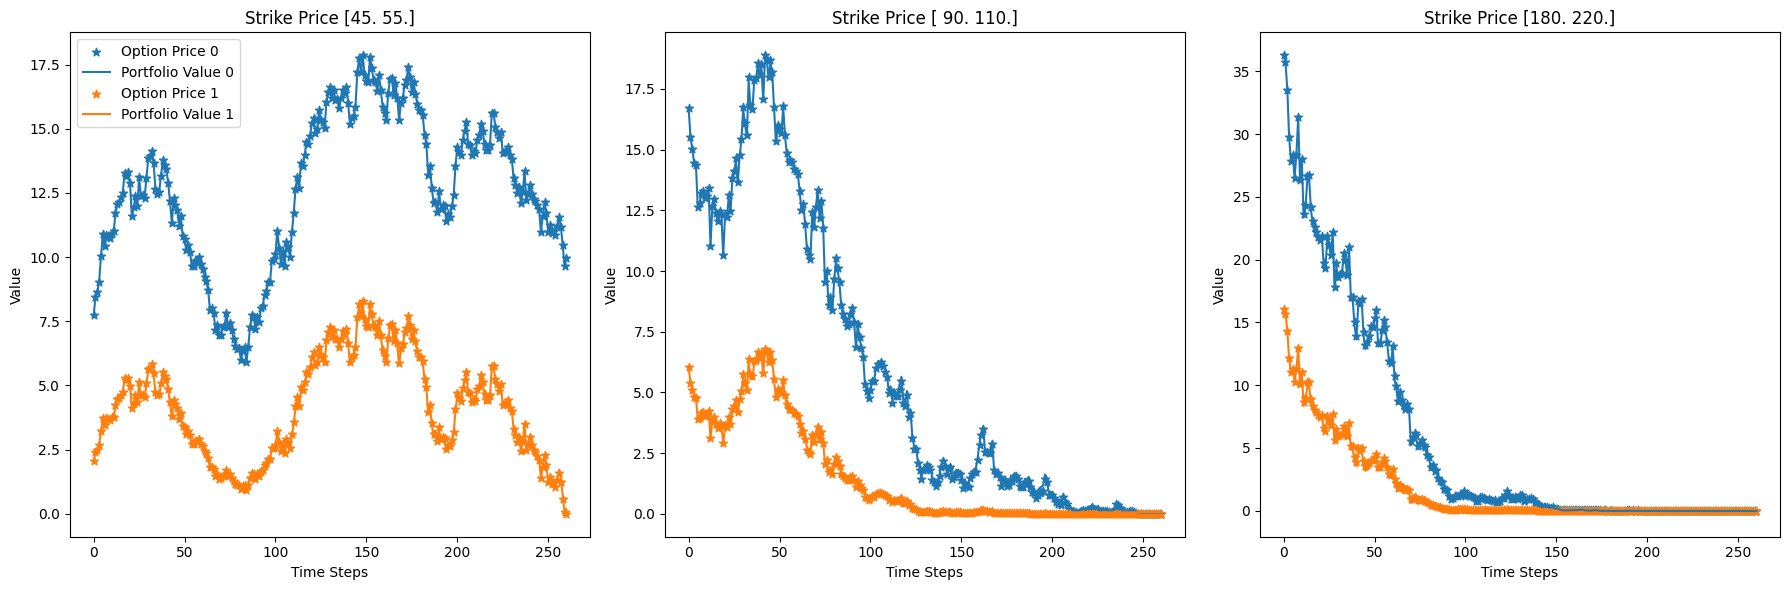

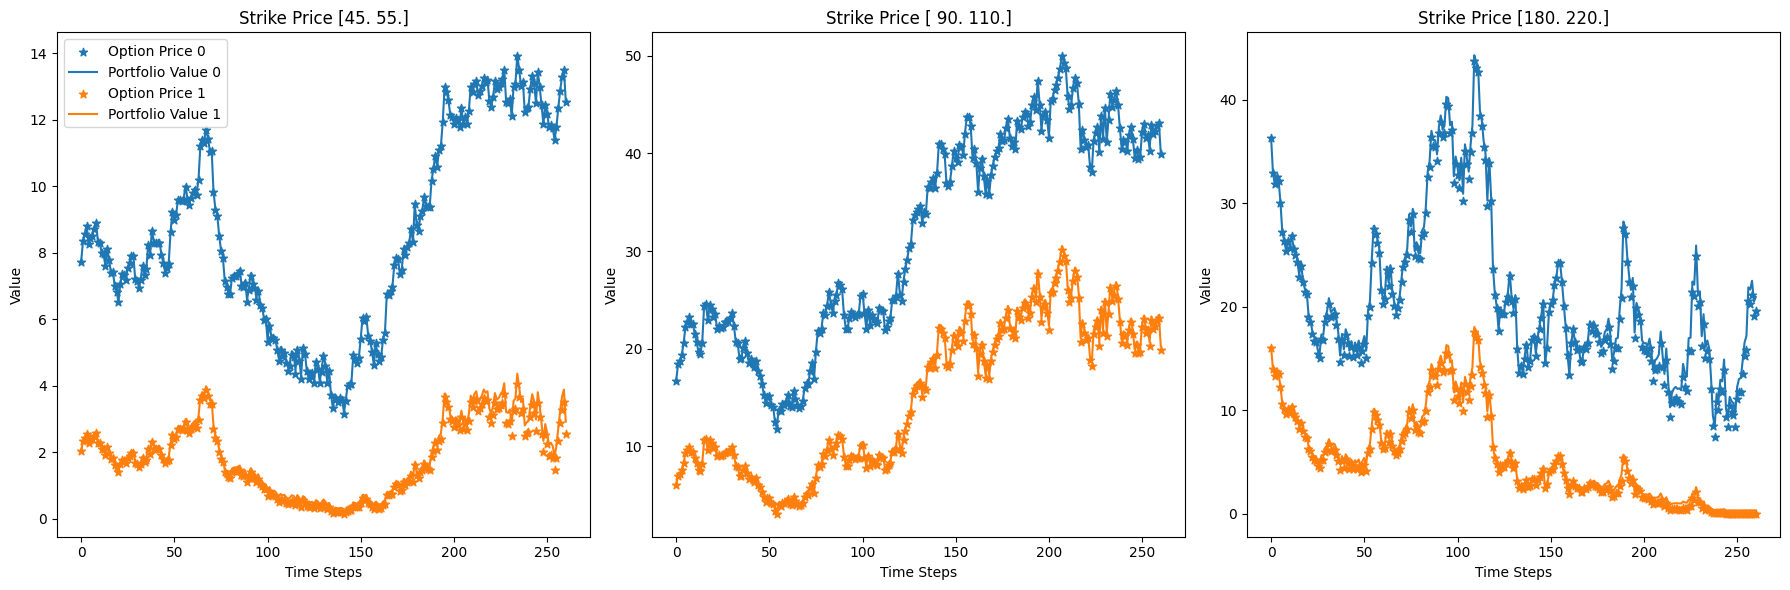

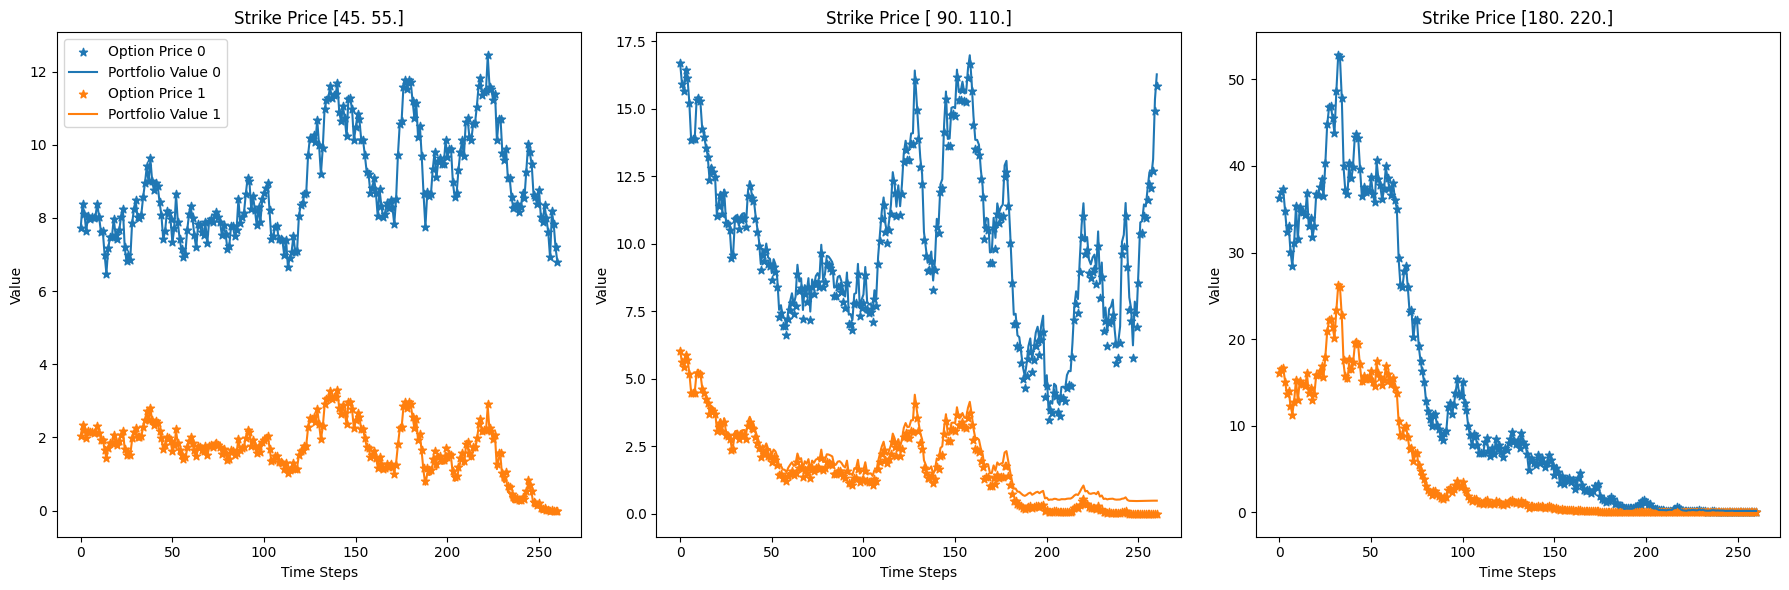

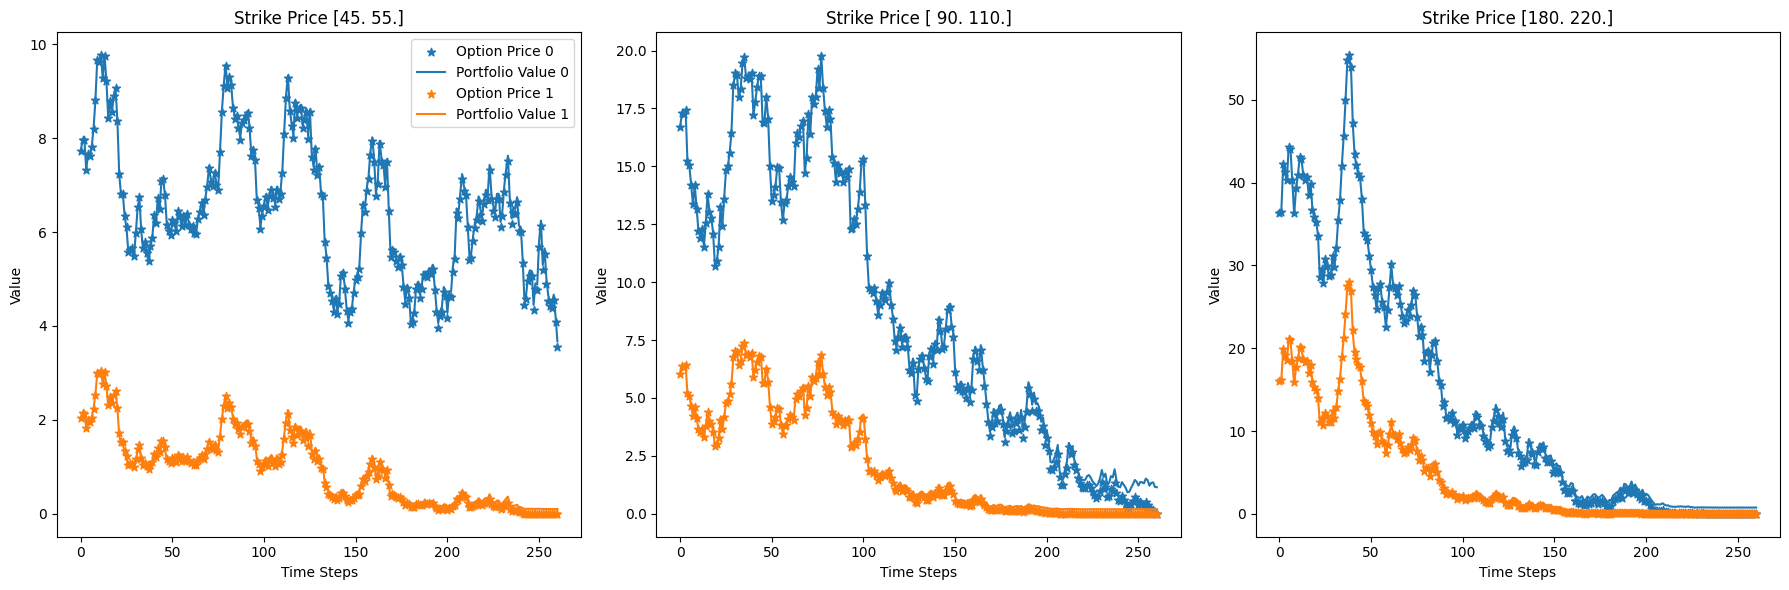

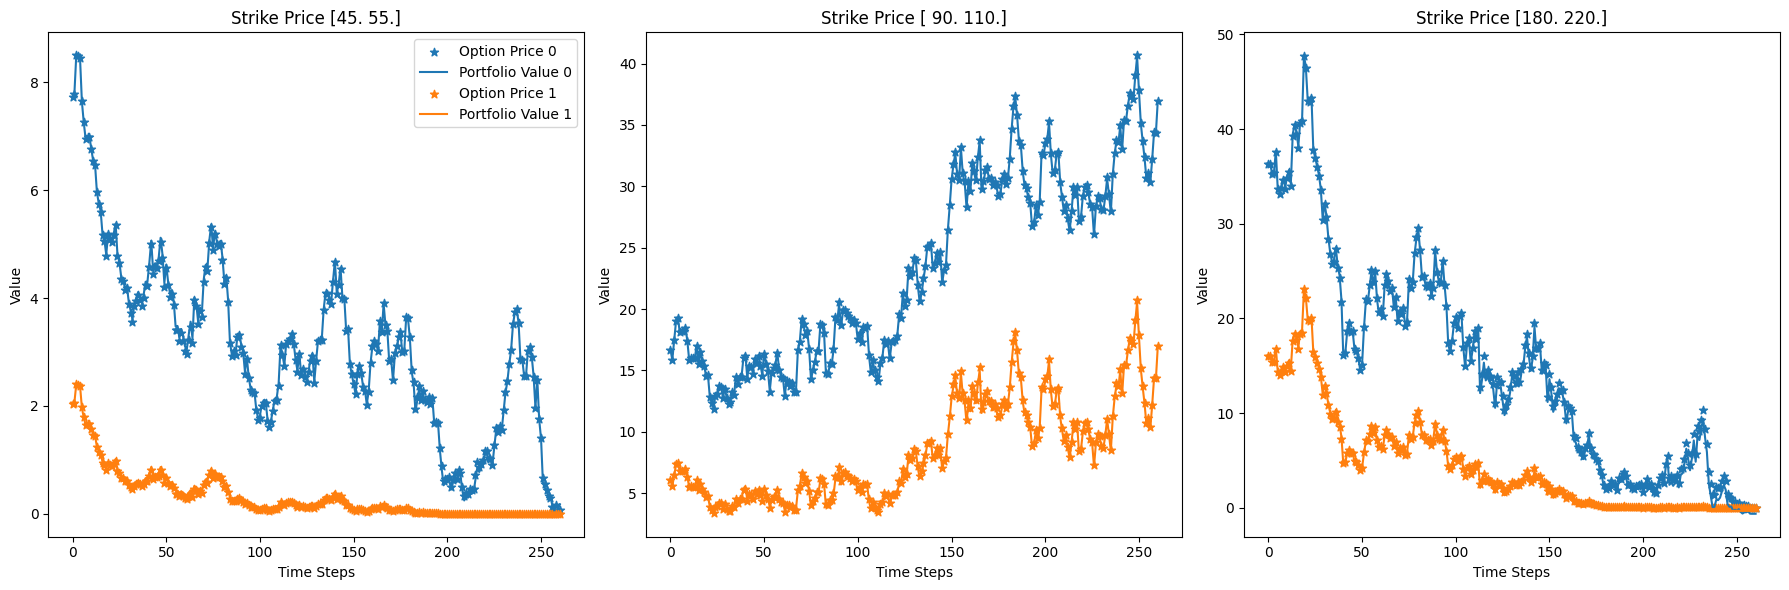

In [17]:
# Plotting the option prices and portfolio values
for idx in range(batch_size):
    fig, axes = plt.subplots(1, len(K), figsize=(18, 6))

    for i in range(num_asset):
        for j in range(num_strike):
            axes[i].scatter(range(option_prices_np.shape[-1]), option_prices_np[idx, i, j, :], marker='*', label=f'Option Price {j}' if i == 0 else "")
            axes[i].plot(portfolio_value_np[idx, i, j, :], linestyle='-', label=f'Portfolio Value {j}' if i == 0 else "")
        axes[i].set_title(f'Strike Price {K[i]}')
        axes[i].set_xlabel('Time Steps')
        axes[i].set_ylabel('Value')
        if i == 0:
            axes[i].legend()

    plt.tight_layout()
    plt.show()